In [ ]:
#HEADER
from PIL import Image
from pylab import *
import numpy as np
import pandas as pd
import glob
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

In [26]:
%%time

#----TRAIN DATA ------
face_path = glob.glob('./train/face/*.pgm')
nonface_path = glob.glob('./train/non-face/*.pgm')

face_count = len(face_path)
nonface_count = len(nonface_path)
total_fn_count = face_count + nonface_count

Ytrain = np.empty((total_fn_count,), dtype='bool')
Ytrain[:face_count] = True
Ytrain[face_count:] = False

filenames = face_path + nonface_path
img = [Image.open(fn).convert('L') for fn in filenames]
Xtrain = np.asarray([np.array(im).flatten() for im in img])
print(Xtrain.shape)

#----TEST DATA ------

face_path = glob.glob('./test/face/*.pgm')                          ### MAKE SURE YOU HAVE SAME PATH
nonface_path = glob.glob('./test/non-face/*.pgm')

face_count = len(face_path)
nonface_count = len(nonface_path)
total_fn_count = face_count + nonface_count

Ytest = np.empty((total_fn_count,), dtype='bool')
Ytest[:face_count] = True
Ytest[face_count:] = False

filenames = face_path + nonface_path
img = [Image.open(fn).convert('L') for fn in filenames]
Xtest = np.asarray([np.array(im).flatten() for im in img])
print(Xtest[:3])



(6977, 361)
[[162 166 167 ..., 178 174 162]
 [ 77  78  80 ..., 211 203 179]
 [145 126 108 ..., 185 190 192]]
CPU times: user 4.11 s, sys: 757 ms, total: 4.86 s
Wall time: 4.89 s


# REGULARIZED GRADIENT DESCENT EXPERIMENT - 2

In [27]:
#Function to calculate sigmoid
def sigmoidFunction(z):
    return 1.0 / (1.0 + np.exp(-z))

In [28]:
#y prediction threshold chcek if yprediction value is greater than 0.5 > then change value to 1 else value to 0
def thresholdgen(ypredc):
    threshold = 0.5
    for i, value in enumerate(ypredc):
        get_sigmoid_threshold = sigmoidFunction(value)
        if get_sigmoid_threshold >= threshold:
            ypredc[i] = 1
        elif get_sigmoid_threshold < threshold:
            ypredc[i] = 0
    #[ypredc[np.abs(ypredc)>0.5] = 0
    if np.all(ypredc==0):
        print("all zeros")
    return ypredc

In [29]:
#Regulatized gradient descent main function
def regularized_gd(Xtrain, Ytrain, alpha, nEpoch, lambdas):
    w = np.random.uniform(size=(Xtrain.shape[1],))
    m = Xtrain.shape[0]
    for epoch in np.arange(0,nEpoch):
        hypothesis = sigmoidFunction(Xtrain.dot(w))
        error = hypothesis - Ytrain  #vector of errors for every samples    
        loss = np.sum(error**2)
        w_square = w.T.dot(w)
        lambdas = float(lambdas/m)
        wj = lambdas * w_square
        gradient = ( Xtrain.T.dot(error) - wj ) / m
        w = w - alpha*gradient
        
    return w

In [49]:
#this function will call regularized GD and calculate accuracy, f1s, recalls, FPR, TPR, thresholds, etc.
def performRGD(Xtrain, Ytrain, alpha, nEpoch, lambdas):
    w = regularized_gd(Xtrain, Ytrain, alpha, nEpoch,lambdas)
    yprediction = Xtest.dot(w)
    yprediction_fit_rgd = thresholdgen(yprediction)
    accuracy = accuracy_score(Ytest, yprediction_fit_rgd)
    precisions = precision_score(Ytest, yprediction_fit_rgd, average=None)
    recalls = recall_score(Ytest, yprediction_fit_rgd, average=None)
    f1s = f1_score(Ytest, yprediction_fit_rgd, average=None)
    fpr, tpr, thresholds = roc_curve(Ytest, yprediction_fit_rgd)
    roc_auc  = auc(fpr, tpr)
    print("ROC FOR BGD-LR")
    print('ROC AUC: %0.2f' % roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return([accuracy, precisions[1], recalls[1], f1s[1], yprediction_fit_rgd])

/home/bhagyashree/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


ROC FOR BGD-LR
ROC AUC: 0.56


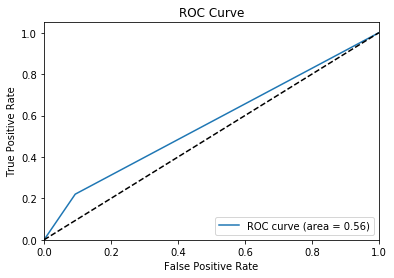

CPU times: user 2.55 s, sys: 56.1 ms, total: 2.61 s
Wall time: 1.5 s


In [50]:
%%time
class_rgd = performRGD(Xtrain,Ytrain,0.1,100,1)
yprediction_fit_rgd = class_rgd[4]


# Stochastic Gradient Descent Experiment - 3

In [33]:
def batching(X, y, batchSize):
    for i in np.arange(0, X.shape[0], batchSize):
        # yield a tuple of the current batched data and labels
        yield (X[i:i + batchSize], y[i:i + batchSize])
        

In [ ]:
import random

# this function takes more amount of time to run as compared to other implementation while when comparing
# both the results both gives same output. I preferred other function which is below this cell as its faster than this.

def sgd_m(Xtrain, Ytrain, alpha, nEpoch, lambdas):
    global lossHistory
    #np.random.seed(9001)
    w = np.random.uniform(size=(Xtrain.shape[1],))
    lossHistory=[]
    m = Xtrain.shape[0]
    for epoch in np.arange(0,nEpoch):
        for i in range(1,m):
            hypothesis = sigmoidFunction(Xtrain.dot(w))
            error = hypothesis - Ytrain  #vector of errors for every samples    
            loss = np.sum(error**2)
            w_square = w.T.dot(w)
            lambdas = float(lambdas/m)
            wj = lambdas * w_square
            gradient = (Xtrain.T.dot(error)- wj)/m
            w = w - alpha*gradient
    return w

In [34]:
import random

def sgd(Xtrain, Ytrain, alpha, nEpoch, lambdas):
    global lossHistory
    #np.random.seed(9001)
    w = np.random.uniform(size=(Xtrain.shape[1],))
    m = Xtrain.shape[0]
    for epoch in np.arange(0,nEpoch):
        for (batchX, batchY) in batching(Xtrain, Ytrain, 512):
            hypothesis = sigmoidFunction(batchX.dot(w))
            error = hypothesis - batchY  #vector of errors for every samples    
            loss = np.sum(error**2)
            w_square = w.T.dot(w)
            lambdas = float(lambdas/m)
            wj = lambdas * w_square
            gradient = (batchX.T.dot(error) - wj)/m
            w = w - alpha*gradient
    return w

In [51]:

def performSGD(Xtrain, Ytrain, alpha, nEpoch, lambdas):
    global yprediction_fit
    w = sgd(Xtrain, Ytrain, alpha, nEpoch,lambdas)
    #w = sgd_m(Xtrain, Ytrain, alpha, nEpoch,lambdas)        # this is an implementaion of sgd with 1 to m for loop
    yprediction = Xtest.dot(w)
    yprediction_fit_sgd = thresholdgen(yprediction) 
    accuracy = accuracy_score(Ytest, yprediction_fit_sgd)
    precisions = precision_score(Ytest, yprediction_fit_sgd, average=None)
    recalls = recall_score(Ytest, yprediction_fit_sgd, average=None)
    f1s = f1_score(Ytest, yprediction_fit_sgd, average=None)
    fpr, tpr, thresholds = roc_curve(Ytest, yprediction_fit_sgd)
    roc_auc  = auc(fpr, tpr)
    print("ROC CURVE FOR STOCHASTIC GD")
    print('ROC AUC: %0.2f' % roc_auc)
    #plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return([accuracy, precisions[1], recalls[1], f1s[1], yprediction_fit_sgd])

/home/bhagyashree/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


ROC CURVE FOR STOCHASTIC GD
ROC AUC: 0.50


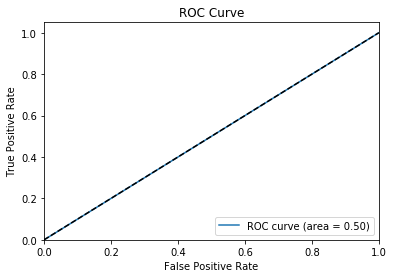

CPU times: user 21.9 s, sys: 219 ms, total: 22.1 s
Wall time: 12.1 s


In [52]:
%%time
class_sgd = performSGD(Xtrain,Ytrain,0.1,1000,1)
yprediction_fit_sgd = class_sgd[4]



# NAIVE BAYES EXPERIMENT - 1

In [45]:
%%time
def fit(Xtrain, Ytrain):
    sample_count, features_count = Xtrain.shape
    c = np.unique(Ytrain)
    c_count = c.shape[0]
 
    w = np.zeros((c_count, features_count))
    sigmoid = np.zeros((c_count, features_count))
    prior_probability_class = np.zeros(c_count)
    eps = 1e-9
    for i, jy in enumerate(c):
        iX = Xtrain[Ytrain == jy, :]
        w[i, :] = np.mean(iX, axis=0)
        sigmoid[i, :] = np.var(iX, axis=0) + eps
        prior_probability_class[i] = np.float(iX.shape[0]) / sample_count
    return w, sigmoid, prior_probability_class
 
def predict(model, X_test, y_test):
    classes = np.unique(y_test)
    n_classes = classes.shape[0]
    joint_log_likelihood = []
    for i in range(n_classes):
        jointi = np.log(model['prior_probability_class'][i])
        n_ij = - 0.5 * np.sum(np.log(2. * np.pi * model['stdev'][i, :]))
        n_ij -= 0.5 * np.sum(((X_test - model['mean'][i, :]) ** 2) /
                             (model['stdev'][i, :]), 1)
        joint_log_likelihood.append(jointi + n_ij)
    joint_log_likelihood = np.array(joint_log_likelihood).T
    return classes[np.argmax(joint_log_likelihood, axis=1)]
 
mean, stdev, prior_probability_class = fit(Xtrain, Ytrain)
data = defaultdict(np.array)
data['mean'] = mean
data['stdev'] = stdev
data['prior_probability_class'] = prior_probability_class
 
yprediction_fit_nb = predict(data, Xtest, Ytest)
 
accuracy_nb= accuracy_score(Ytest, yprediction_fit_nb)
precisions_nb = precision_score(Ytest, yprediction_fit_nb, average=None)
recalls_nb = recall_score(Ytest, yprediction_fit_nb, average=None)
f1s_nb = f1_score(Ytest, yprediction_fit_nb, average=None)
 

CPU times: user 142 ms, sys: 100 ms, total: 242 ms
Wall time: 245 ms


ROC CURVE FOR NAIVE BAYES
ROC AUC: 0.60


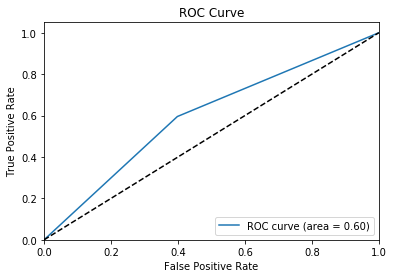

In [47]:
print("ROC CURVE FOR NAIVE BAYES")
fpr, tpr, thresholds = roc_curve(Ytest, yprediction_fit_nb)
roc_auc  = auc(fpr, tpr)
print('ROC AUC: %0.2f' % roc_auc)
    #plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# A single ROC plot containing the 3 ROC curves for the NB, BGD-LR and SGD-LR.

ROC AUC for Naive Bayes: 0.60
ROC AUC for BGD-LR: 0.56
ROC AUC for SGD-LR: 0.50


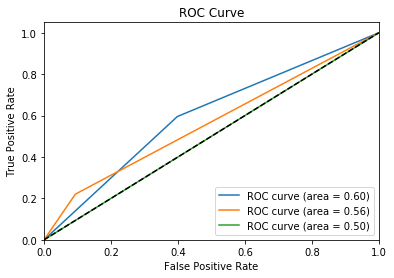

In [16]:
fpr, tpr, thresholds = roc_curve(Ytest, yprediction_fit_nb)
roc_auc  = auc(fpr, tpr)
print('ROC AUC for Naive Bayes: %0.2f' % roc_auc)
    #plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(Ytest, yprediction_fit_rgd)
roc_auc  = auc(fpr, tpr)
print('ROC AUC for BGD-LR: %0.2f' % roc_auc)
    #plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(Ytest, yprediction_fit_sgd)
roc_auc  = auc(fpr, tpr)
print('ROC AUC for SGD-LR: %0.2f' % roc_auc)
    #plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# A table listing the performance metrics: Accuracy, Precision, Recall, F 1 -measure of the three methods based on the three experiments you did: NB, BGD-LR, SGD-LR

In [17]:
df =pd.DataFrame.from_records([{'':'NAIVE-BAYES','nEpoch, Alpha, Lambda': '-', 'Accuracy':accuracy_nb,'Precision':precisions_nb[1], 'Recall': recalls_nb[1], 'F-1':f1s_nb[1]},
                              {'':'BGD-LR','nEpoch, Alpha, Lambda': '100, 0.1, 1', 'Accuracy':class_rgd[0],'Precision':class_rgd[1], 'Recall': class_rgd[2], 'F-1':class_rgd[3]},
                               {'':'SGD-LR','nEpoch, Alpha, Lambda': '1000, 0.1, 1', 'Accuracy':class_sgd[0],'Precision':class_sgd[1], 'Recall': class_sgd[2], 'F-1':class_sgd[3]}
                              ], columns=['','nEpoch, Alpha, Lambda','Accuracy','Precision', 'Recall', 'F-1'])
df

,,"nEpoch, Alpha, Lambda",Accuracy,Precision,Recall,F-1
0,NAIVE-BAYES,-,0.601705,0.029068,0.595339,0.055430
1,BGD-LR,"100, 0.1, 1",0.893159,0.045119,0.220339,0.074901
2,SGD-LR,"1000, 0.1, 1",0.972260,0.019704,0.008475,0.011852
